In [2]:
import graphlab
import math
import random
import numpy
from matplotlib import pyplot as plt
%matplotlib inline

A newer version of GraphLab Create (v1.8.5) is available! Your current version is v1.8.3.

You can use pip to upgrade the graphlab-create package. For more information see https://dato.com/products/create/upgrade.


Create random avlues for x in interval [0,1)

In [3]:
random.seed(98103)
n = 30
x = graphlab.SArray([random.random() for i in range(n)]).sort()

[INFO] GraphLab Create v1.8.3 started. Logging: C:\Users\PUHFI_~1\AppData\Local\Temp\graphlab_server_1460573535.log.0


compute y

In [4]:
y = x.apply(lambda x: math.sin(4*x))

add random Gaussian noise to y

In [5]:
random.seed(1)
e = graphlab.SArray([random.gauss(0, 1.0/3.0) for i in range(n)])
y = y + e

Put data into an SFrame to manipulate late

In [6]:
data = graphlab.SFrame({'X1':x, 'Y':y})
data

X1,Y
0.0395789449501,0.587050191026
0.0415680996791,0.648655851372
0.0724319480801,0.307803309485
0.150289044622,0.310748447417
0.161334144502,0.237409625496
0.191956312795,0.705017157224
0.232833917145,0.461716676992
0.259900980166,0.383260507851
0.380145814869,1.06517691429
0.432444723508,1.03184706949


Create a function to plot the data, since we'll do it many times

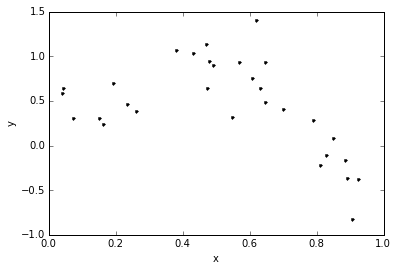

In [7]:
def plot_data(data):
    plt.plot(data['X1'], data['Y'], 'k.')
    plt.xlabel('x')
    plt.ylabel('y')
    
plot_data(data)

#Define some useful polynomial regression functions
Define a function to create our features for a polynomial regression model of any degree:

In [8]:
def polynomial_features(data, deg):
    #data is an SFrame
    data_copy = data.copy()
    for i in range(1, deg):
        data_copy['X'+str(i+1)]=data_copy['X'+str(i)]*data_copy['X1']
    return data_copy

define a function to fit a polynomial linear regression model of degree 'deg' to the data in "data":

In [9]:
def polynomial_regression(data, deg):
    model = graphlab.linear_regression.create(polynomial_features(data, deg),
                                             target='Y', l2_penalty=0.,l1_penalty=0.,
                                             validation_set=None, verbose=False)
    return model

Define function to plot data and predictions made, since we are going to use it many times

In [10]:
def plot_poly_predictions(data, model):
    plot_data(data)
    
    #get the degree of the polynomial
    deg = len(model.coefficients['value'])-1
    
    #Create 200 points in the x axis and comput the predicted value for each point
    x_pred = graphlab.SFrame({'X1':[i/200.0 for i in range(200)]})
    y_pred = model.predict(polynomial_features(x_pred, deg))
    
    #plot predictions
    plt.plot(x_pred['X1'], y_pred, 'g-', label='degree ' + str(deg) + ' fit')
    plt.legend(loc='upper left')
    plt.axis([0,1,-1.5,2])

Create a function that prints the polynomial coefficients in a pretty way ;)

In [11]:
def print_coefficients(model):
    #Get the degree of the polynomial
    deg = len(model.coefficients['value'])-1
    
    #Get the learned parameters as a list
    w = list(model.coefficients['value'])
    
    #Numpy has a nifty function to print out polynomials in a pretty way
    # (We'll use it, but it needs the parameters in the reverse order)
    print 'Learned polynomial for degree ' + str(deg) + ':'
    w.reverse()
    print numpy.poly1d(w)

#Fit a degree-2 polynomial
Fit our degree-2 polynomial to the data generated above:

In [12]:
model = polynomial_regression(data, deg=2)

Inspect learned parameters

In [13]:
print_coefficients(model)

Learned polynomial for degree 2:
        2
-5.129 x + 4.147 x + 0.07471


###Form and plot our predictions along a grid of x values:

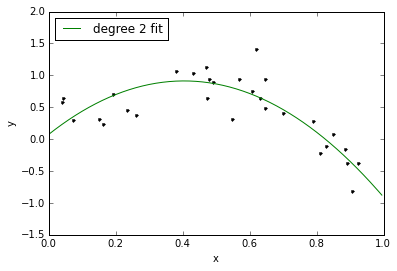

In [14]:
plot_poly_predictions(data, model)

###Fit a degree-4 polynomial

Learned polynomial for degree 4:
       4         3         2
23.87 x - 53.82 x + 35.23 x - 6.828 x + 0.7755


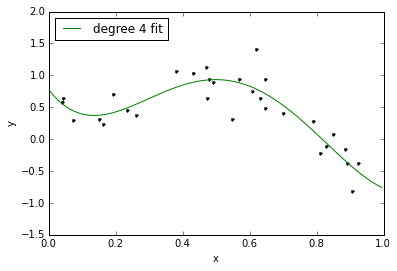

In [15]:
model = polynomial_regression(data, deg=4)
print_coefficients(model)
plot_poly_predictions(data, model)


###Fit a degree-16 polynomial

In [16]:
model = polynomial_regression(data, deg=16)
print_coefficients(model)

Learned polynomial for degree 16:
            16             15             14            13
-4.537e+05 x  + 1.129e+06 x  + 4.821e+05 x  - 3.81e+06 x 
              12             11             10             9
 + 3.536e+06 x  + 5.753e+04 x  - 1.796e+06 x  + 2.178e+06 x
              8             7            6             5             4
 - 3.662e+06 x + 4.442e+06 x - 3.13e+06 x + 1.317e+06 x - 3.356e+05 x
             3        2
 + 5.06e+04 x - 4183 x + 160.8 x - 1.621


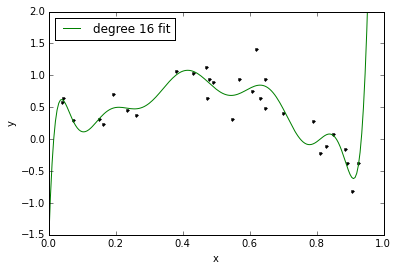

In [17]:
plot_poly_predictions(data, model)

###^Overfit

#Ridge Regression

Ridge regression aims to avoid overfitting by adding a cost to the RSS term of standard least squares that depends on something something something norm of coefficients ||w||. The resut is penalizing fits with large coefficients. The strength of this penalty , and something something something model complexity balance, is controlled by a parameter lambda (here called "L2_penalty")

In [20]:
def polynomial_ridge_regression(data, deg, l2_penalty):
    model = graphlab.linear_regression.create(polynomial_features(data, deg),
                                             target='Y', l2_penalty=l2_penalty,
                                             validation_set=None, verbose=False)
    return model

###Perform a ridge fit of a degree-16 polynomial using a very small penalty strength

In [21]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=1e-25)
print_coefficients(model)

Learned polynomial for degree 16:
            16             15             14            13
-4.537e+05 x  + 1.129e+06 x  + 4.821e+05 x  - 3.81e+06 x 
              12             11             10             9
 + 3.536e+06 x  + 5.753e+04 x  - 1.796e+06 x  + 2.178e+06 x
              8             7            6             5             4
 - 3.662e+06 x + 4.442e+06 x - 3.13e+06 x + 1.317e+06 x - 3.356e+05 x
             3        2
 + 5.06e+04 x - 4183 x + 160.8 x - 1.621


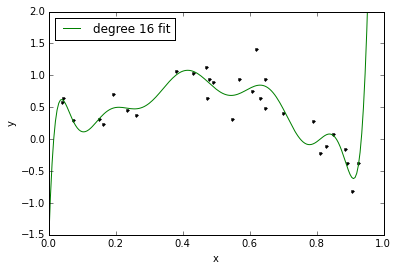

In [22]:
plot_poly_predictions(data, model)

###Perform a ridge fit of a degree-16 polynomial using a very large penalty strength

In [24]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=100)
print_coefficients(model)

Learned polynomial for degree 16:
        16          15          14          13          12         11
-0.301 x  - 0.2802 x  - 0.2604 x  - 0.2413 x  - 0.2229 x  - 0.205 x 
           10          9          8          7          6           5
 - 0.1874 x  - 0.1699 x - 0.1524 x - 0.1344 x - 0.1156 x - 0.09534 x
            4           3           2
 - 0.07304 x - 0.04842 x - 0.02284 x - 0.002257 x + 0.6416


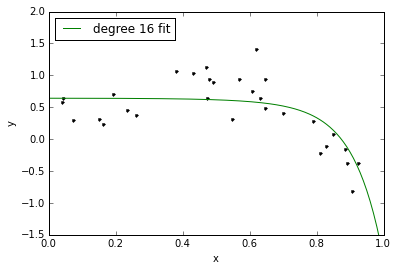

In [25]:
plot_poly_predictions(data, model)

##Let's look at fits for a sequence of increasing lambda values

lambda = 1.00e-25
Learned polynomial for degree 16:
            16             15             14            13
-4.537e+05 x  + 1.129e+06 x  + 4.821e+05 x  - 3.81e+06 x 
              12             11             10             9
 + 3.536e+06 x  + 5.753e+04 x  - 1.796e+06 x  + 2.178e+06 x
              8             7            6             5             4
 - 3.662e+06 x + 4.442e+06 x - 3.13e+06 x + 1.317e+06 x - 3.356e+05 x
             3        2
 + 5.06e+04 x - 4183 x + 160.8 x - 1.621


lambda = 1.00e-10
Learned polynomial for degree 16:
           16             15             14             13
4.975e+04 x  - 7.821e+04 x  - 2.265e+04 x  + 3.949e+04 x 
              12        11             10             9             8
 + 4.366e+04 x  + 3074 x  - 3.332e+04 x  - 2.786e+04 x + 1.032e+04 x
              7        6             5             4        3         2
 + 2.962e+04 x - 1440 x - 2.597e+04 x + 1.839e+04 x - 5596 x + 866.1 x - 65.19 x + 2.159


lambda = 1.00e-03
Learned polyn

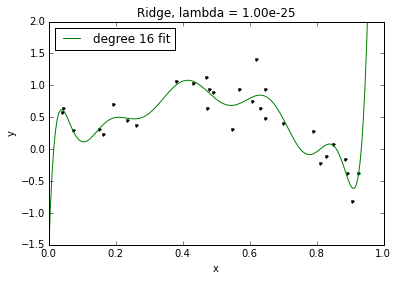

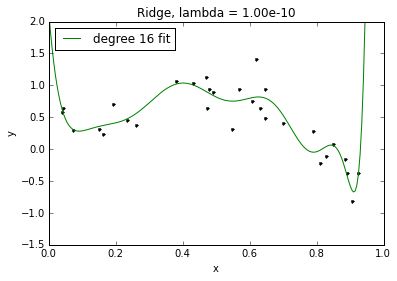

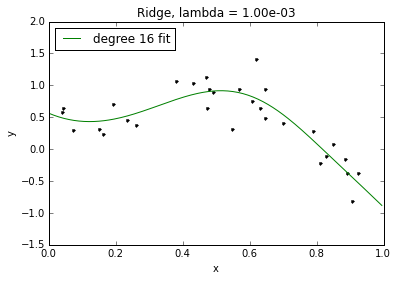

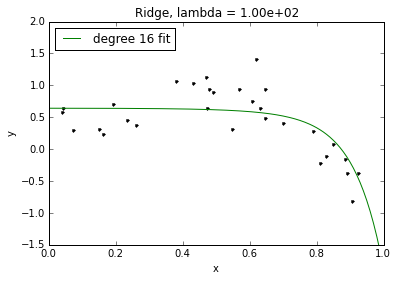

In [27]:
for l2_penalty in [1e-25, 1e-10, 1e-3, 1e2]:
    model = polynomial_ridge_regression(data, deg=16, l2_penalty=l2_penalty)
    print 'lambda = %.2e' % l2_penalty
    print_coefficients(model)
    print '\n'
    plt.figure()
    plot_poly_predictions(data, model)
    plt.title('Ridge, lambda = %.2e' % l2_penalty)

###Perform a ridge fit of a degree-16 polynomial using a "good" penalty strength

We will learn about cross validation later in this course as a way to select a good value of the tuning parameter (penalty strength) lambda. Here, we consider "leave one out" 
(LOO) cross validation, which one can show approximates average mean square error (MSE). As a result, choosing lambda to minimiz
the LOO error is equivalent to choosing lambda to minimize an approximation to average MSE.

In [38]:
def loo(data, deg, l2_penalty_values):
    #create polynomial features
    polynomial_features(data, deg)
    
    #Create as many folds for cross validation as number of data points
    num_folds = len(data)
    folds = graphlab.cross_validation.KFold(data, num_folds)
    
    #for each value of L2_penalty, fit a model for each fold and compute average MSE
    l2_penalty_mse = []
    min_mse = None
    best_l2_penalty = None
    for l2_penalty in l2_penalty_values:
        next_mse = 0.0
        for train_set, validation_set in folds:
            #train model
            model = graphlab.linear_regression.create(train_set, target='Y', l2_penalty=l2_penalty,
                                                     validation_set=None, verbose=False)
            
            #predict validation set
            y_test_predicted = model.predict(validation_set)
            #compute squared error
            next_mse += ((y_test_predicted-validation_set['Y'])**2).sum()
        #save squared error in list of MSE for each l2_penalty
        next_mse = next_mse/num_folds
        l2_penalty_mse.append(next_mse)
        if min_mse is None or next_mse < min_mse:
                min_mse = next_mse
                best_l2_penalty = l2_penalty
                
    return l2_penalty_mse, best_l2_penalty

Run LOO cross validation for "num" values of lambda on log scale

In [39]:
l2_penalty_values = numpy.logspace(-4, 10, num=10)
l2_penalty_mse, best_l2_penalty = loo(data, 16, l2_penalty_values)

Plot results of estimating LOO for each value of lambda

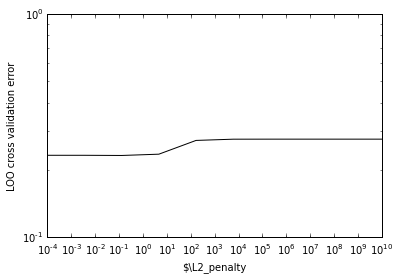

In [40]:
plt.plot(l2_penalty_values, l2_penalty_mse, 'k-')
plt.xlabel("$\L2_penalty")
plt.ylabel("LOO cross validation error")
plt.xscale("log")
plt.yscale("log")

In [41]:
best_l2_penalty

0.12915496650148839

In [42]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=best_l2_penalty)
print_coefficients(model)

Learned polynomial for degree 16:
       16         15          14          13          12           11
1.345 x  + 1.141 x  + 0.9069 x  + 0.6447 x  + 0.3569 x  + 0.04947 x 
           10          9          8         7         6         5
 - 0.2683 x  - 0.5821 x - 0.8701 x - 1.099 x - 1.216 x - 1.145 x
           4           3          2
 - 0.7837 x - 0.07406 x + 0.7614 x + 0.7703 x + 0.3918


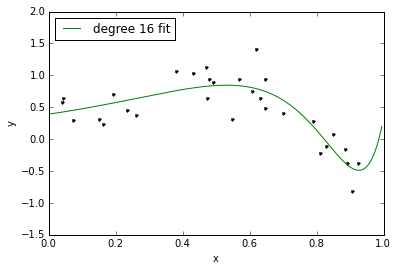

In [43]:
plot_poly_predictions(data, model)